# Bibliotecas

In [350]:
# Manipulação e estruturação
import pandas as pd
import numpy as np

# Modelagem
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit

# Avaliação
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Pré-processamento
from sklearn.preprocessing import StandardScaler

# Visualização
import matplotlib.pyplot as plt



# Preparação dos Dados

In [351]:
df = pd.read_csv("../../camada_ouro/2010-2021.csv", parse_dates=["Date"])
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

In [352]:
# Limpeza de colunas com %
df['Change%_Petro'] = df['Change%_Petro'].str.replace('%', '').astype(float) / 100
df['Value_IPCA'] = df['Value_IPCA'].str.replace('%', '').astype(float) / 100
df['Change%_Ibovespa'] = df['Change%_Ibovespa'].astype("str")
df['Change%_Ibovespa'] = df['Change%_Ibovespa'].str.replace('%', '').astype(float) / 100

display(df)

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA
0,2010-01-04,2010-01-04 16:56:00,37.937621,13303743.87,22.005581,81.51,263.54,0.0271,70045.08,0.003999,0.0075
1,2010-01-05,2010-01-05 16:56:00,37.774220,21396519.48,21.927335,81.77,258.89,0.0032,70239.82,-0.037754,0.0075
2,2010-01-06,2010-01-06 16:56:00,38.805357,18720547.15,22.382971,83.18,370.06,0.0172,70729.34,-0.025855,0.0075
3,2010-01-07,2010-01-07 16:56:00,36.425929,10964646.19,20.918813,82.66,246.63,-0.0063,70451.12,0.012930,0.0075
4,2010-01-08,2010-01-08 16:56:00,35.037787,14624078.31,20.148239,82.75,310.38,0.0011,70262.70,0.013341,0.0075
...,...,...,...,...,...,...,...,...,...,...,...
2879,2021-12-23,2021-12-23 18:00:00,28.558526,28713576.27,5.443348,73.42,95.32,0.0151,104891.32,0.011939,0.0073
2880,2021-12-27,2021-12-27 18:00:00,28.375663,44228016.62,5.403242,75.18,76.67,0.0240,105554.40,-0.007603,0.0073
2881,2021-12-28,2021-12-28 18:00:00,28.816555,30688070.54,5.543991,75.60,66.33,0.0056,104864.17,-0.007954,0.0073
2882,2021-12-29,2021-12-29 18:00:00,27.394061,35508521.20,5.298555,76.18,78.61,0.0077,104107.24,0.012578,0.0073


In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2884 entries, 0 to 2883
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               2884 non-null   datetime64[ns]
 1   Datetime           2884 non-null   object        
 2   Close_Real_EYAC2   2884 non-null   float64       
 3   Volume_EYAC2       2884 non-null   float64       
 4   Close_Dolar_EYAC2  2884 non-null   float64       
 5   Price_Dolar_Petro  2884 non-null   float64       
 6   Volume_Petro       2884 non-null   float64       
 7   Change%_Petro      2884 non-null   float64       
 8   Índice_Ibovespa    2884 non-null   float64       
 9   Change%_Ibovespa   2884 non-null   float64       
 10  Value_IPCA         2884 non-null   float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 248.0+ KB


Alvo

In [354]:
df['target'] = df['Close_Real_EYAC2'].shift(-1)  # prever o preço da ação no próximo dia

# Feature Engineering 

### Retornos percentuais diários

In [355]:
df['retorno_acao'] = df['Close_Real_EYAC2'].pct_change()
df['retorno_petro'] = df['Price_Dolar_Petro'].pct_change()

df.tail()


,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro
2879,2021-12-23,2021-12-23 18:00:00,28.558526,28713576.27,5.443348,73.42,95.32,0.0151,104891.32,0.011939,0.0073,28.375663,0.059489,0.015070
2880,2021-12-27,2021-12-27 18:00:00,28.375663,44228016.62,5.403242,75.18,76.67,0.0240,105554.40,-0.007603,0.0073,28.816555,-0.006403,0.023972
2881,2021-12-28,2021-12-28 18:00:00,28.816555,30688070.54,5.543991,75.60,66.33,0.0056,104864.17,-0.007954,0.0073,27.394061,0.015538,0.005587
2882,2021-12-29,2021-12-29 18:00:00,27.394061,35508521.20,5.298555,76.18,78.61,0.0077,104107.24,0.012578,0.0073,26.880488,-0.049364,0.007672
2883,2021-12-30,2021-12-30 18:00:00,26.880488,43229146.50,5.182980,76.61,61.02,0.0056,104822.44,0.028524,0.0073,NaN,-0.018748,0.005645


### Médias móveis

In [356]:
df['mm7_acao'] = df['Close_Real_EYAC2'].rolling(7).mean()

df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao
2879,2021-12-23,2021-12-23 18:00:00,28.558526,28713576.27,5.443348,73.42,95.32,0.0151,104891.32,0.011939,0.0073,28.375663,0.059489,0.015070,28.545617
2880,2021-12-27,2021-12-27 18:00:00,28.375663,44228016.62,5.403242,75.18,76.67,0.0240,105554.40,-0.007603,0.0073,28.816555,-0.006403,0.023972,28.469630
2881,2021-12-28,2021-12-28 18:00:00,28.816555,30688070.54,5.543991,75.60,66.33,0.0056,104864.17,-0.007954,0.0073,27.394061,0.015538,0.005587,28.097957
2882,2021-12-29,2021-12-29 18:00:00,27.394061,35508521.20,5.298555,76.18,78.61,0.0077,104107.24,0.012578,0.0073,26.880488,-0.049364,0.007672,27.777438
2883,2021-12-30,2021-12-30 18:00:00,26.880488,43229146.50,5.182980,76.61,61.02,0.0056,104822.44,0.028524,0.0073,NaN,-0.018748,0.005645,27.782619


### Volatilidade

In [357]:
df['vol_7_acao'] = df['Close_Real_EYAC2'].rolling(7).std()
df['vol_30_acao'] = df['Close_Real_EYAC2'].rolling(30).std()


df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao
2879,2021-12-23,2021-12-23 18:00:00,28.558526,28713576.27,5.443348,73.42,95.32,0.0151,104891.32,0.011939,0.0073,28.375663,0.059489,0.015070,28.545617,1.637993,1.466586
2880,2021-12-27,2021-12-27 18:00:00,28.375663,44228016.62,5.403242,75.18,76.67,0.0240,105554.40,-0.007603,0.0073,28.816555,-0.006403,0.023972,28.469630,1.630725,1.180152
2881,2021-12-28,2021-12-28 18:00:00,28.816555,30688070.54,5.543991,75.60,66.33,0.0056,104864.17,-0.007954,0.0073,27.394061,0.015538,0.005587,28.097957,1.033965,1.175486
2882,2021-12-29,2021-12-29 18:00:00,27.394061,35508521.20,5.298555,76.18,78.61,0.0077,104107.24,0.012578,0.0073,26.880488,-0.049364,0.007672,27.777438,0.797921,1.170655
2883,2021-12-30,2021-12-30 18:00:00,26.880488,43229146.50,5.182980,76.61,61.02,0.0056,104822.44,0.028524,0.0073,NaN,-0.018748,0.005645,27.782619,0.790939,1.150912


### Defasagens

In [358]:
df['lag1_acao'] = df['Close_Real_EYAC2'].shift(1)
df['lag60_acao'] = df['Close_Real_EYAC2'].shift(60)


df.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
2879,2021-12-23,2021-12-23 18:00:00,28.558526,28713576.27,5.443348,73.42,95.32,0.0151,104891.32,0.011939,0.0073,28.375663,0.059489,0.015070,28.545617,1.637993,1.466586,26.955004,27.975101
2880,2021-12-27,2021-12-27 18:00:00,28.375663,44228016.62,5.403242,75.18,76.67,0.0240,105554.40,-0.007603,0.0073,28.816555,-0.006403,0.023972,28.469630,1.630725,1.180152,28.558526,25.050923
2881,2021-12-28,2021-12-28 18:00:00,28.816555,30688070.54,5.543991,75.60,66.33,0.0056,104864.17,-0.007954,0.0073,27.394061,0.015538,0.005587,28.097957,1.033965,1.175486,28.375663,22.556466
2882,2021-12-29,2021-12-29 18:00:00,27.394061,35508521.20,5.298555,76.18,78.61,0.0077,104107.24,0.012578,0.0073,26.880488,-0.049364,0.007672,27.777438,0.797921,1.170655,28.816555,28.975428
2883,2021-12-30,2021-12-30 18:00:00,26.880488,43229146.50,5.182980,76.61,61.02,0.0056,104822.44,0.028524,0.0073,NaN,-0.018748,0.005645,27.782619,0.790939,1.150912,27.394061,28.542898


In [359]:
df_test = df[['Date','target','retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao','lag1_acao', 'lag60_acao']]
display(df_test)

,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2010-01-04,37.774220,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,38.805357,-0.004307,NaN,NaN,NaN,37.937621,NaN
2,2010-01-06,36.425929,0.027297,NaN,NaN,NaN,37.774220,NaN
3,2010-01-07,35.037787,-0.061317,NaN,NaN,NaN,38.805357,NaN
4,2010-01-08,36.103721,-0.038109,NaN,NaN,NaN,36.425929,NaN
...,...,...,...,...,...,...,...,...
2879,2021-12-23,28.375663,0.059489,28.545617,1.637993,1.466586,26.955004,27.975101
2880,2021-12-27,28.816555,-0.006403,28.469630,1.630725,1.180152,28.558526,25.050923
2881,2021-12-28,27.394061,0.015538,28.097957,1.033965,1.175486,28.375663,22.556466
2882,2021-12-29,26.880488,-0.049364,27.777438,0.797921,1.170655,28.816555,28.975428


# Tratamento dos dados

Essas transformações geram valores NaN no início da série, por exemplo:

pct_change() → NaN na primeira linha

rolling(7).mean() → NaN nas 6 primeiras linhas

shift(1) → NaN na primeira linha

Esses NaNs atrapalham o treino do modelo e precisam ser removidos antes de separar treino/teste ou aplicar model.fit().

In [360]:
# Copiar o DataFrame original para df_model
df_nan = df.copy()

# Preencher os NaN restantes usando o valor posterior (bfill)
df_nan[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]] = \
df_nan[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]].fillna(method='bfill')

# Verificar se ainda há NaN após preenchimento com bfill 
nan_counts_after_filling = df_nan[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]].isna().sum()

print("Após interpolação e bfill, contagem de NaN:", nan_counts_after_filling)

# Visualizar as primeiras linhas após o preenchimento
print(df_nan.head())


Após interpolação e bfill, contagem de NaN: lag1_acao        0
lag60_acao       0
mm7_acao         0
vol_7_acao       0
vol_30_acao      0
retorno_acao     0
retorno_petro    0
dtype: int64
        Date             Datetime  Close_Real_EYAC2  Volume_EYAC2  \
0 2010-01-04  2010-01-04 16:56:00         37.937621   13303743.87   
1 2010-01-05  2010-01-05 16:56:00         37.774220   21396519.48   
2 2010-01-06  2010-01-06 16:56:00         38.805357   18720547.15   
3 2010-01-07  2010-01-07 16:56:00         36.425929   10964646.19   
4 2010-01-08  2010-01-08 16:56:00         35.037787   14624078.31   

   Close_Dolar_EYAC2  Price_Dolar_Petro  Volume_Petro  Change%_Petro  \
0          22.005581              81.51        263.54         0.0271   
1          21.927335              81.77        258.89         0.0032   
2          22.382971              83.18        370.06         0.0172   
3          20.918813              82.66        246.63        -0.0063   
4          20.148239              8

C:\Users\FM972EJ\AppData\Local\Temp\ipykernel_14364\4236721217.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'retorno_acao', 'retorno_petro',]].fillna(method='bfill')


In [361]:
df_nan.isna().sum()

Date                 0
Datetime             0
Close_Real_EYAC2     0
Volume_EYAC2         0
Close_Dolar_EYAC2    0
Price_Dolar_Petro    0
Volume_Petro         0
Change%_Petro        0
Índice_Ibovespa      0
Change%_Ibovespa     0
Value_IPCA           0
target               1
retorno_acao         0
retorno_petro        0
mm7_acao             0
vol_7_acao           0
vol_30_acao          0
lag1_acao            0
lag60_acao           0
dtype: int64

In [362]:
df_model = df_nan.dropna().copy()   

df_model.tail(2)
# df_model.to_csv('../../camada_ouro/teste.csv')

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
2881,2021-12-28,2021-12-28 18:00:00,28.816555,30688070.54,5.543991,75.60,66.33,0.0056,104864.17,-0.007954,0.0073,27.394061,0.015538,0.005587,28.097957,1.033965,1.175486,28.375663,22.556466
2882,2021-12-29,2021-12-29 18:00:00,27.394061,35508521.20,5.298555,76.18,78.61,0.0077,104107.24,0.012578,0.0073,26.880488,-0.049364,0.007672,27.777438,0.797921,1.170655,28.816555,28.975428


In [363]:
df_model.isna().sum()

Date                 0
Datetime             0
Close_Real_EYAC2     0
Volume_EYAC2         0
Close_Dolar_EYAC2    0
Price_Dolar_Petro    0
Volume_Petro         0
Change%_Petro        0
Índice_Ibovespa      0
Change%_Ibovespa     0
Value_IPCA           0
target               0
retorno_acao         0
retorno_petro        0
mm7_acao             0
vol_7_acao           0
vol_30_acao          0
lag1_acao            0
lag60_acao           0
dtype: int64

In [364]:
df_test1 = df_model[['Date','target','retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao','lag1_acao', 'lag60_acao']]
display(df_test1)


,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2010-01-04,37.774220,-0.004307,37.327009,1.518331,2.169266,37.937621,37.937621
1,2010-01-05,38.805357,-0.004307,37.327009,1.518331,2.169266,37.937621,37.937621
2,2010-01-06,36.425929,0.027297,37.327009,1.518331,2.169266,37.774220,37.937621
3,2010-01-07,35.037787,-0.061317,37.327009,1.518331,2.169266,38.805357,37.937621
4,2010-01-08,36.103721,-0.038109,37.327009,1.518331,2.169266,36.425929,37.937621
...,...,...,...,...,...,...,...,...
2878,2021-12-22,28.558526,-0.019748,28.618866,1.650087,1.502829,27.498036,27.180750
2879,2021-12-23,28.375663,0.059489,28.545617,1.637993,1.466586,26.955004,27.975101
2880,2021-12-27,28.816555,-0.006403,28.469630,1.630725,1.180152,28.558526,25.050923
2881,2021-12-28,27.394061,0.015538,28.097957,1.033965,1.175486,28.375663,22.556466


In [365]:

data_reduced = df_model.drop(columns=['Date','Datetime'])

# Calcular a variabilidade (desvio padrão) das features numéricas restantes
variability = data_reduced.std()

# Calcular a correlação entre as features
correlation_matrix = data_reduced.corr()

# Exibir a variabilidade
print("Variabilidade das Features:")
display(variability)

# Exibir a matriz de correlação
print("Matriz de Correlação das Features:")
display(correlation_matrix)

Variabilidade das Features:


Close_Real_EYAC2     6.893244e+00
Volume_EYAC2         3.165586e+07
Close_Dolar_EYAC2    4.298726e+00
Price_Dolar_Petro    2.205293e+01
Volume_Petro         1.731260e+02
Change%_Petro        2.821280e-02
Índice_Ibovespa      2.254459e+04
Change%_Ibovespa     9.450581e-02
Value_IPCA           3.447785e-03
target               6.886357e+00
retorno_acao         1.449856e-01
retorno_petro        2.462677e-02
mm7_acao             6.744187e+00
vol_7_acao           4.907543e-01
vol_30_acao          6.044327e-01
lag1_acao            6.899939e+00
lag60_acao           7.264426e+00
dtype: float64

Matriz de Correlação das Features:


,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
Close_Real_EYAC2,1.000000,-0.081885,0.644031,0.319545,-0.299044,0.005946,0.633394,0.149315,-0.062999,0.951705,0.072599,0.025215,0.973389,0.048401,0.033968,0.951801,0.784006
Volume_EYAC2,-0.081885,1.000000,-0.457105,-0.433703,0.056874,0.034143,0.331532,-0.084841,0.072530,-0.082056,0.002386,0.005245,-0.073305,0.168072,0.325332,-0.072596,-0.065009
Close_Dolar_EYAC2,0.644031,-0.457105,1.000000,0.673793,-0.137037,-0.016472,-0.126425,0.060373,-0.064587,0.613830,0.031074,0.003494,0.634925,0.010369,-0.045706,0.617505,0.628882
Price_Dolar_Petro,0.319545,-0.433703,0.673793,1.000000,-0.251954,-0.015313,-0.272960,0.044594,0.064328,0.317686,-0.038662,0.018160,0.327741,0.008795,-0.107531,0.319641,0.287815
Volume_Petro,-0.299044,0.056874,-0.137037,-0.251954,1.000000,0.008761,-0.245227,-0.068799,-0.026469,-0.301324,0.008871,-0.006263,-0.296596,0.011132,-0.026232,-0.289900,-0.258961
Change%_Petro,0.005946,0.034143,-0.016472,-0.015313,0.008761,1.000000,0.027066,0.008544,-0.014367,0.013931,0.059331,0.837174,-0.014185,-0.029284,-0.007423,-0.017977,-0.005723
Índice_Ibovespa,0.633394,0.331532,-0.126425,-0.272960,-0.245227,0.027066,1.000000,0.147970,-0.000435,0.633586,-0.032721,0.028515,0.639808,0.058824,0.095919,0.630370,0.447206
Change%_Ibovespa,0.149315,-0.084841,0.060373,0.044594,-0.068799,0.008544,0.147970,1.000000,-0.005624,0.152735,0.010362,0.059362,0.125950,-0.004989,-0.230833,0.142572,-0.116724
Value_IPCA,-0.062999,0.072530,-0.064587,0.064328,-0.026469,-0.014367,-0.000435,-0.005624,1.000000,-0.063559,0.017639,0.008805,-0.063272,-0.038531,-0.045209,-0.062736,-0.080769
target,0.951705,-0.082056,0.613830,0.317686,-0.301324,0.013931,0.633586,0.152735,-0.063559,1.000000,-0.047143,0.028493,0.963219,0.044910,0.033489,0.944821,0.782667


# Definindo Features e Target

In [366]:
# Atualizando as features
feature_names = [
    'lag1_acao',
    'lag60_acao',
    'mm7_acao',
    'vol_7_acao',
    'vol_30_acao',
    'Price_Dolar_Petro',
    'Índice_Ibovespa',
    'retorno_acao',
    'retorno_petro',
]


# Definindo X (features) e y (target)
X = df_model[feature_names]
y = df_model['target']

# Padronização

In [377]:
# Inicializando o scaler
scaler = StandardScaler()

# Padronizando as features
X_scaled = scaler.fit_transform(X)

# Separar Treino e teste

In [378]:
split_date = '2021-12-31'

train = df_model[df_model['Date'] < split_date]     # Treinamento: 2010–2021
# test = df_model[df_model['Date'] >= split_date]     # Teste: 2022–2024

X_train = train[feature_names]
y_train = train['target']
# X_test = test[feature_names]
# y_test = test['target']

# Padronizando os dados de treino e teste
X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


# Treinamento e Validação

### RandomForest

In [379]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_train)

# Avaliação de desempenho
mae_rf = mean_absolute_error(y_train, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_train, y_pred_rf))
r2_rf = r2_score(y_train, y_pred_rf)

print("Random Forest - MAE:", mae_rf)
print("Random Forest - RMSE:", rmse_rf)
print("Random Forest - R²:", r2_rf)


Random Forest - MAE: 0.5411660472144167
Random Forest - RMSE: 0.6827907229946001
Random Forest - R²: 0.9901656223732703


### LinearRegression

In [380]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_train_scaled)

# Avaliação de desempenho
mae_lr = mean_absolute_error(y_train, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_train, y_pred_lr))
r2_lr = r2_score(y_train, y_pred_lr)

print("Linear Regression - MAE:", mae_lr)
print("Linear Regression - RMSE:", rmse_lr)
print("Linear Regression - R²:", r2_lr)


Linear Regression - MAE: 1.4306196853999553
Linear Regression - RMSE: 1.796350486259336
Linear Regression - R²: 0.9319303043525435


### RidgeRegression

In [381]:
ridge_model = Ridge()
ridge_model.fit(X_train_scaled, y_train)
y_pred_ridge = ridge_model.predict(X_train_scaled)

# Avaliação de desempenho
mae_ridge = mean_absolute_error(y_train, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_train, y_pred_ridge))
r2_ridge = r2_score(y_train, y_pred_ridge)

print("Ridge Regression - MAE:", mae_ridge)
print("Ridge Regression - RMSE:", rmse_ridge)
print("Ridge Regression - R²:", r2_ridge)


Ridge Regression - MAE: 1.4307407427209207
Ridge Regression - RMSE: 1.7963641098473486
Ridge Regression - R²: 0.9319292718624885


### LassoRegression

In [382]:
lasso_model = Lasso()
lasso_model.fit(X_train_scaled, y_train)
y_pred_lasso = lasso_model.predict(X_train_scaled)

# Avaliação de desempenho
mae_lasso = mean_absolute_error(y_train, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_train, y_pred_lasso))
r2_lasso = r2_score(y_train, y_pred_lasso)

print("Lasso Regression - MAE:", mae_lasso)
print("Lasso Regression - RMSE:", rmse_lasso)
print("Lasso Regression - R²:", r2_lasso)


Lasso Regression - MAE: 1.6719458395972322
Lasso Regression - RMSE: 2.100620534181413
Lasso Regression - R²: 0.9069177505311843


### XGBoost

In [383]:
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_train)

# Avaliação de desempenho
mae_xgb = mean_absolute_error(y_train, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_train, y_pred_xgb))
r2_xgb = r2_score(y_train, y_pred_xgb)

print("XGBoost - MAE:", mae_xgb)
print("XGBoost - RMSE:", rmse_xgb)
print("XGBoost - R²:", r2_xgb)


XGBoost - MAE: 0.3476177866965835
XGBoost - RMSE: 0.4681724072579947
XGBoost - R²: 0.9953763677410167


### Comparação entre modelos

In [384]:
# Criar um DataFrame para comparar as métricas
results = pd.DataFrame({
    'Model': ['Random Forest', 'Linear Regression', 'Ridge Regression', 'Lasso Regression', 'XGBoost'],
    'MAE': [mae_rf, mae_lr, mae_ridge, mae_lasso, mae_xgb],
    'RMSE': [rmse_rf, rmse_lr, rmse_ridge, rmse_lasso, rmse_xgb],
    'R²': [r2_rf, r2_lr, r2_ridge, r2_lasso, r2_xgb]
})

display(results)

,Model,MAE,RMSE,R²
0,Random Forest,0.541166,0.682791,0.990166
1,Linear Regression,1.430620,1.796350,0.931930
2,Ridge Regression,1.430741,1.796364,0.931929
3,Lasso Regression,1.671946,2.100621,0.906918
4,XGBoost,0.347618,0.468172,0.995376


### Validação cruzada temporal

In [385]:
# Definindo TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)  # 5 divisões

# Função para avaliar cada modelo com TimeSeriesSplit
def evaluate_model_with_ts_split(model, X_train, y_train):
    mae_list = []
    rmse_list = []
    r2_list = []

    for train_index, val_index in tscv.split(X_train):
        X_train_split, X_val_split = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_split, y_val_split = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Treinando o modelo
        model.fit(X_train_split, y_train_split)
        
        # Fazendo previsões
        y_pred = model.predict(X_val_split)
        
        # Calculando as métricas
        mae = mean_absolute_error(y_val_split, y_pred)
        rmse = np.sqrt(mean_squared_error(y_val_split, y_pred))
        r2 = r2_score(y_val_split, y_pred)
        
        # Armazenando as métricas para o split
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)
    
    # Calculando as médias das métricas
    mean_mae = np.mean(mae_list)
    mean_rmse = np.mean(rmse_list)
    mean_r2 = np.mean(r2_list)
    
    return mean_mae, mean_rmse, mean_r2

# Avaliação de cada modelo com TimeSeriesSplit
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Armazenando os resultados
results = []

# Avaliar todos os modelos
for name, model in models.items():
    mae, rmse, r2 = evaluate_model_with_ts_split(model, X_train, y_train)
    results.append([name, mae, rmse, r2])

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'R²'])
display(results_df)


,Model,MAE,RMSE,R²
0,Random Forest,2.449889,2.955867,0.278020
1,Linear Regression,1.513441,1.898647,0.743254
2,Ridge Regression,1.504122,1.890741,0.745522
3,Lasso Regression,1.737622,2.160267,0.661390
4,XGBoost,2.734001,3.311625,0.141496


# Visualização (melhor modelo, Ridge)

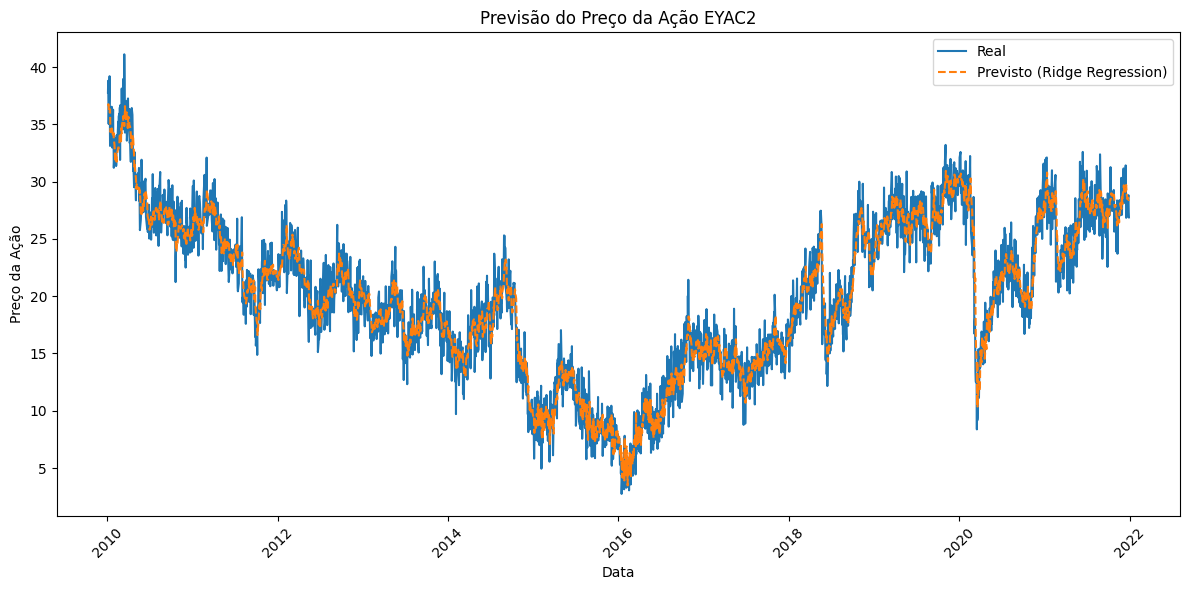

In [386]:
# Plotando as previsões vs reais
plt.figure(figsize=(12,6))
plt.plot(train['Date'], y_train, label='Real')
plt.plot(train['Date'], y_pred_ridge, label='Previsto (Ridge Regression)', linestyle='--')  # Previsões do RandomForest
plt.legend()
plt.title("Previsão do Preço da Ação EYAC2")
plt.xlabel('Data')
plt.ylabel('Preço da Ação')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajustar para que os elementos não se sobreponham
plt.show()


# Erros residuais

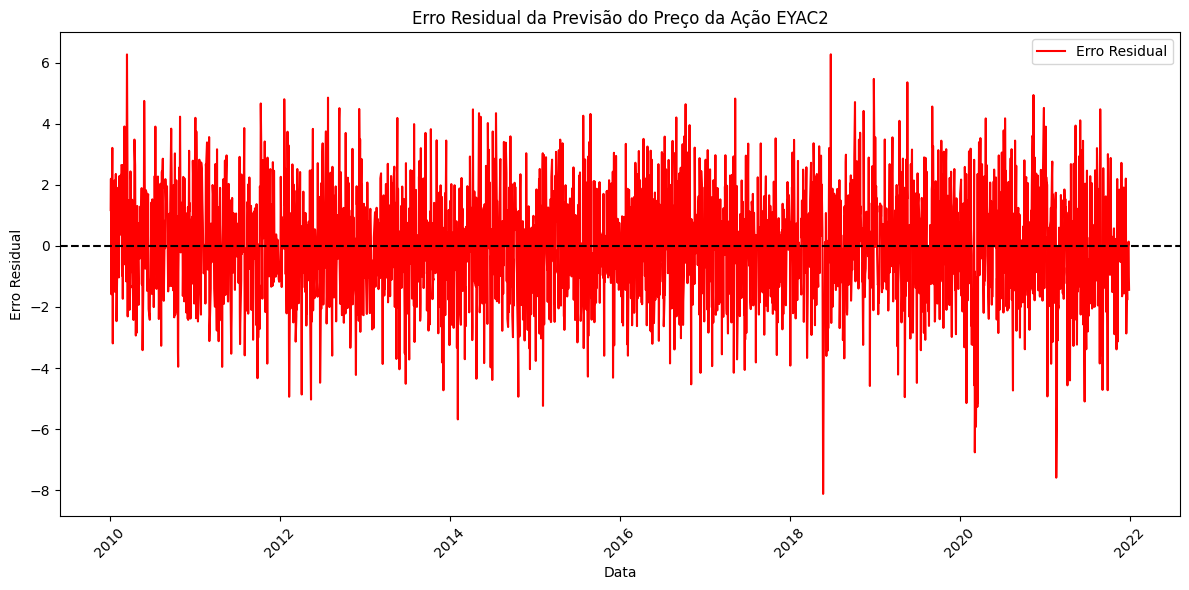

In [387]:
# Calculando os resíduos
residuals = y_train - y_pred_ridge

# Plotando os resíduos
plt.figure(figsize=(12,6))
plt.plot(train['Date'], residuals, label='Erro Residual', color='red')
plt.axhline(0, color='black', linestyle='--')  # Linha horizontal em y=0
plt.legend()
plt.title("Erro Residual da Previsão do Preço da Ação EYAC2")
plt.xlabel('Data')
plt.ylabel('Erro Residual')
plt.xticks(rotation=45)  # Para facilitar a leitura das datas
plt.tight_layout()  # Ajuste para que os elementos não se sobreponham
plt.show()


# Previsões 2022 -  2024

In [388]:
df_preds = pd.read_csv("../../camada_ouro/2022-2024.csv", parse_dates=["Date"])
df_preds['Date'] = pd.to_datetime(df_preds['Date'])
df_preds = df_preds.sort_values('Date')

In [389]:
# Limpeza de colunas com %
df_preds['Change%_Petro'] = df_preds['Change%_Petro'].str.replace('%', '').astype(float) / 100
df_preds['Value_IPCA'] = df_preds['Value_IPCA'].str.replace('%', '').astype(float) / 100
df_preds['Change%_Ibovespa'] = df_preds['Change%_Ibovespa'].astype("str")
df_preds['Change%_Ibovespa'] = df_preds['Change%_Ibovespa'].str.replace('%', '').astype(float) / 100

display(df_preds)

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA
0,2022-01-03,2022-01-03 16:56:00,30.423610,52705026.77,5.888175,75.85,112.23,0.0130,103921.59,-0.071498,0.0054
1,2022-01-04,2022-01-04 16:56:00,31.247251,51739287.55,6.064248,76.74,156.45,0.0117,103513.64,-0.114484,0.0054
2,2022-01-05,2022-01-05 16:56:00,28.882186,78459838.11,5.698707,77.47,197.97,0.0095,101005.64,-0.145146,0.0054
3,2022-01-06,2022-01-06 16:56:00,28.065536,61163141.76,5.479838,78.88,244.00,0.0182,101561.05,-0.071666,0.0054
4,2022-01-07,2022-01-07 16:56:00,27.966914,47507585.90,5.443258,78.44,229.28,-0.0056,102719.47,-0.067785,0.0054
...,...,...,...,...,...,...,...,...,...,...,...
742,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052
743,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052
744,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052
745,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052


In [390]:
df_preds['target'] = None 

In [391]:
df_preds['retorno_acao'] = df_preds['Close_Real_EYAC2'].pct_change()
df_preds['retorno_petro'] = df_preds['Price_Dolar_Petro'].pct_change()

df_preds.tail()


,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro
742,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,None,0.073694,-0.005189
743,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,None,0.012217,-0.003043
744,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,None,-0.036942,0.006104
745,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,None,-0.047555,0.013722
746,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,None,0.015178,0.004987


In [392]:
df_preds['mm7_acao'] = df_preds['Close_Real_EYAC2'].rolling(7).mean()

df_preds.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao
742,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,None,0.073694,-0.005189,36.752494
743,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,None,0.012217,-0.003043,36.891896
744,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,None,-0.036942,0.006104,37.193168
745,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,None,-0.047555,0.013722,36.978142
746,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,None,0.015178,0.004987,37.267763


In [393]:
df_preds['vol_7_acao'] = df_preds['Close_Real_EYAC2'].rolling(7).std()
df_preds['vol_30_acao'] = df_preds['Close_Real_EYAC2'].rolling(30).std()


df_preds.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao
742,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,None,0.073694,-0.005189,36.752494,1.537777,2.077662
743,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,None,0.012217,-0.003043,36.891896,1.737403,2.032447
744,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,None,-0.036942,0.006104,37.193168,1.690363,2.007464
745,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,None,-0.047555,0.013722,36.978142,1.729424,1.930767
746,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,None,0.015178,0.004987,37.267763,1.400747,1.951400


In [394]:
df_preds['lag1_acao'] = df_preds['Close_Real_EYAC2'].shift(1)
df_preds['lag60_acao'] = df_preds['Close_Real_EYAC2'].shift(60)


df_preds.tail()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
742,2024-12-20,2024-12-20 16:56:00,38.845595,59277431.74,7.123841,69.02,114.62,-0.0052,122102.15,-0.068388,0.0052,None,0.073694,-0.005189,36.752494,1.537777,2.077662,36.179398,37.552839
743,2024-12-23,2024-12-23 16:56:00,39.320157,43785532.81,7.206377,68.81,90.95,-0.0030,120766.57,-0.065514,0.0052,None,0.012217,-0.003043,36.891896,1.737403,2.032447,38.845595,33.950358
744,2024-12-26,2024-12-26 16:56:00,37.867609,22920777.53,6.977118,69.23,69.64,-0.0059,121077.50,-0.068078,0.0052,None,-0.036942,0.006104,37.193168,1.690363,2.007464,39.320157,37.068349
745,2024-12-27,2024-12-27 16:56:00,36.066818,24167282.36,6.597186,70.18,79.13,0.0137,120269.31,-0.057957,0.0052,None,-0.047555,0.013722,36.978142,1.729424,1.930767,37.867609,32.458720
746,2024-12-30,2024-12-30 16:56:00,36.614223,22355586.67,6.605965,70.53,93.10,0.0050,120283.40,-0.079271,0.0052,None,0.015178,0.004987,37.267763,1.400747,1.951400,36.066818,34.809688


In [395]:
df_test = df_preds[['Date','target','retorno_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao','lag1_acao', 'lag60_acao']]
display(df_test)
# df_test.to_csv('../../camada_ouro/target.csv', index=False)

,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2022-01-03,None,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-04,None,0.027072,NaN,NaN,NaN,30.423610,NaN
2,2022-01-05,None,-0.075689,NaN,NaN,NaN,31.247251,NaN
3,2022-01-06,None,-0.028275,NaN,NaN,NaN,28.882186,NaN
4,2022-01-07,None,-0.003514,NaN,NaN,NaN,28.065536,NaN
...,...,...,...,...,...,...,...,...
742,2024-12-20,None,0.073694,36.752494,1.537777,2.077662,36.179398,37.552839
743,2024-12-23,None,0.012217,36.891896,1.737403,2.032447,38.845595,33.950358
744,2024-12-26,None,-0.036942,37.193168,1.690363,2.007464,39.320157,37.068349
745,2024-12-27,None,-0.047555,36.978142,1.729424,1.930767,37.867609,32.458720


In [396]:
# Copiar o DataFrame original para df_model
df_nan1 = df_preds.copy()

# Preencher os NaN restantes usando o valor posterior (bfill)
df_nan1[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]] = \
df_nan1[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]].fillna(method='bfill')

# Verificar se ainda há NaN após preenchimento com bfill 
nan_counts_after_filling = df_nan1[['lag1_acao', 'lag60_acao', 'mm7_acao', 'vol_7_acao', 'vol_30_acao', 
          'retorno_acao', 'retorno_petro',]].isna().sum()

print("Após interpolação e bfill, contagem de NaN:", nan_counts_after_filling)

# Visualizar as primeiras linhas após o preenchimento
print(df_nan1.head())

# Salvar o DataFrame resultante em um arquivo CSV
# df_nan.to_csv('../../camada_ouro/teste_completo.csv', index=False)


Após interpolação e bfill, contagem de NaN: lag1_acao        0
lag60_acao       0
mm7_acao         0
vol_7_acao       0
vol_30_acao      0
retorno_acao     0
retorno_petro    0
dtype: int64
        Date             Datetime  Close_Real_EYAC2  Volume_EYAC2  \
0 2022-01-03  2022-01-03 16:56:00         30.423610   52705026.77   
1 2022-01-04  2022-01-04 16:56:00         31.247251   51739287.55   
2 2022-01-05  2022-01-05 16:56:00         28.882186   78459838.11   
3 2022-01-06  2022-01-06 16:56:00         28.065536   61163141.76   
4 2022-01-07  2022-01-07 16:56:00         27.966914   47507585.90   

   Close_Dolar_EYAC2  Price_Dolar_Petro  Volume_Petro  Change%_Petro  \
0           5.888175              75.85        112.23         0.0130   
1           6.064248              76.74        156.45         0.0117   
2           5.698707              77.47        197.97         0.0095   
3           5.479838              78.88        244.00         0.0182   
4           5.443258              7

C:\Users\FM972EJ\AppData\Local\Temp\ipykernel_14364\3078703860.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  'retorno_acao', 'retorno_petro',]].fillna(method='bfill')


In [397]:
df_nan1.isna().sum()

Date                   0
Datetime               0
Close_Real_EYAC2       0
Volume_EYAC2           0
Close_Dolar_EYAC2      0
Price_Dolar_Petro      0
Volume_Petro           0
Change%_Petro          0
Índice_Ibovespa        0
Change%_Ibovespa       0
Value_IPCA             0
target               747
retorno_acao           0
retorno_petro          0
mm7_acao               0
vol_7_acao             0
vol_30_acao            0
lag1_acao              0
lag60_acao             0
dtype: int64

In [398]:
df_preds = df_nan1.copy()

In [399]:
df_test1 = df_preds[['Date','target','retorno_acao','mm7_acao', 'vol_7_acao', 'vol_30_acao', 'lag1_acao','lag60_acao']]
display(df_test1)


# df_test.to_csv('../../camada_ouro/target.csv', index=False)

,Date,target,retorno_acao,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2022-01-03,None,0.027072,29.157610,1.231475,2.294205,30.423610,30.423610
1,2022-01-04,None,0.027072,29.157610,1.231475,2.294205,30.423610,30.423610
2,2022-01-05,None,-0.075689,29.157610,1.231475,2.294205,31.247251,30.423610
3,2022-01-06,None,-0.028275,29.157610,1.231475,2.294205,28.882186,30.423610
4,2022-01-07,None,-0.003514,29.157610,1.231475,2.294205,28.065536,30.423610
...,...,...,...,...,...,...,...,...
742,2024-12-20,None,0.073694,36.752494,1.537777,2.077662,36.179398,37.552839
743,2024-12-23,None,0.012217,36.891896,1.737403,2.032447,38.845595,33.950358
744,2024-12-26,None,-0.036942,37.193168,1.690363,2.007464,39.320157,37.068349
745,2024-12-27,None,-0.047555,36.978142,1.729424,1.930767,37.867609,32.458720


In [400]:
feature_names1 = [
    'lag1_acao',
    'lag60_acao',
    'mm7_acao',
    'vol_7_acao',
    'vol_30_acao',
    'Price_Dolar_Petro',
    'Índice_Ibovespa',
    'retorno_acao',
    'retorno_petro',
]


# Dados de teste (2022 a 2024) com target NaN
test_data = df_preds[df_preds['Date'] >= '2022-01-01']
X_test = test_data[feature_names1]

# Escalonamento dos dados de teste
X_test_scaled = scaler.transform(X_test)

# Fazer previsões para os valores de target ausentes
y_pred = ridge_model.predict(X_test_scaled)

# Preencher o target de 2022 a 2024 com as previsões
df_preds.loc[df_preds['Date'] >= '2022-01-01', 'target'] = y_pred



In [401]:
# Previsões para 2022-2024
future_preds = []

# Selecionar os dados de 2022 a 2024 para previsão
predict_data = df_preds[(df_preds['Date'] >= '2022-01-01') & (df_preds['Date'] <= '2024-12-31')]

# Verificar e preencher valores nulos nas features (se necessário)
predict_data[feature_names1] = predict_data[feature_names1].fillna(predict_data[feature_names1].mean())

# Normalizar as features do conjunto de previsão
X_predict = predict_data[feature_names1]
X_predict_scaled = scaler.transform(X_predict)

# Realizar as previsões
predictions = ridge_model.predict(X_predict_scaled)

# Armazenar as previsões e atualizar no DataFrame
for idx, predicted_target in zip(predict_data.index, predictions):
    df_preds.at[idx, 'target'] = predicted_target
    future_preds.append((df_preds.at[idx, 'Date'], predicted_target))

# Exibir as previsões
future_preds_df = pd.DataFrame(future_preds, columns=['Date', 'Predicted_Target'])
display(future_preds_df)

# Salvar previsões em CSV
future_preds_df.to_csv('../../camada_ouro/previsoes_2022_2024.csv', index=False)


,Date,Predicted_Target
0,2022-01-03,29.728542
1,2022-01-04,29.730338
2,2022-01-05,29.632035
3,2022-01-06,29.280038
4,2022-01-07,29.009670
...,...,...
742,2024-12-20,36.641763
743,2024-12-23,37.078941
744,2024-12-26,37.424926
745,2024-12-27,36.868314


In [402]:
df_preds.head()

,Date,Datetime,Close_Real_EYAC2,Volume_EYAC2,Close_Dolar_EYAC2,Price_Dolar_Petro,Volume_Petro,Change%_Petro,Índice_Ibovespa,Change%_Ibovespa,Value_IPCA,target,retorno_acao,retorno_petro,mm7_acao,vol_7_acao,vol_30_acao,lag1_acao,lag60_acao
0,2022-01-03,2022-01-03 16:56:00,30.423610,52705026.77,5.888175,75.85,112.23,0.0130,103921.59,-0.071498,0.0054,29.728542,0.027072,0.011734,29.15761,1.231475,2.294205,30.423610,30.42361
1,2022-01-04,2022-01-04 16:56:00,31.247251,51739287.55,6.064248,76.74,156.45,0.0117,103513.64,-0.114484,0.0054,29.730338,0.027072,0.011734,29.15761,1.231475,2.294205,30.423610,30.42361
2,2022-01-05,2022-01-05 16:56:00,28.882186,78459838.11,5.698707,77.47,197.97,0.0095,101005.64,-0.145146,0.0054,29.632035,-0.075689,0.009513,29.15761,1.231475,2.294205,31.247251,30.42361
3,2022-01-06,2022-01-06 16:56:00,28.065536,61163141.76,5.479838,78.88,244.00,0.0182,101561.05,-0.071666,0.0054,29.280038,-0.028275,0.018201,29.15761,1.231475,2.294205,28.882186,30.42361
4,2022-01-07,2022-01-07 16:56:00,27.966914,47507585.90,5.443258,78.44,229.28,-0.0056,102719.47,-0.067785,0.0054,29.00967,-0.003514,-0.005578,29.15761,1.231475,2.294205,28.065536,30.42361


In [403]:
df_preds.isna().sum()

Date                 0
Datetime             0
Close_Real_EYAC2     0
Volume_EYAC2         0
Close_Dolar_EYAC2    0
Price_Dolar_Petro    0
Volume_Petro         0
Change%_Petro        0
Índice_Ibovespa      0
Change%_Ibovespa     0
Value_IPCA           0
target               0
retorno_acao         0
retorno_petro        0
mm7_acao             0
vol_7_acao           0
vol_30_acao          0
lag1_acao            0
lag60_acao           0
dtype: int64

In [404]:
import pandas as pd

# Garantir que as datas estão no formato datetime
df_model['Date'] = pd.to_datetime(df_model['Date'])
df_preds['Date'] = pd.to_datetime(df_preds['Date'])

# Obter os dados reais (até 2021) de df_model
real_data_model = df_model[df_model['Date'] <= '2021-12-31']

# Obter os dados previstos (2022-2024) de df_preds
pred_data_preds = df_preds[(df_preds['Date'] >= '2022-01-01') & (df_preds['Date'] <= '2024-12-31')]

# Adicionar as previsões ao df_model
# Vamos concatenar os dados reais de 2021 com as previsões de 2022 a 2024
df_model_with_preds = pd.concat([real_data_model[['Date', 'target']], pred_data_preds[['Date', 'target']].rename(columns={'target': 'target'})], ignore_index=True)

# Exibir o DataFrame com as previsões adicionadas
display(df_model_with_preds)

# Salvar o DataFrame atualizado em um arquivo CSV
df_model_with_preds.to_csv('df_model_with_predictions.csv', index=False)


,Date,target
0,2010-01-04,37.77422
1,2010-01-05,38.805357
2,2010-01-06,36.425929
3,2010-01-07,35.037787
4,2010-01-08,36.103721
...,...,...
3625,2024-12-20,36.641763
3626,2024-12-23,37.078941
3627,2024-12-26,37.424926
3628,2024-12-27,36.868314


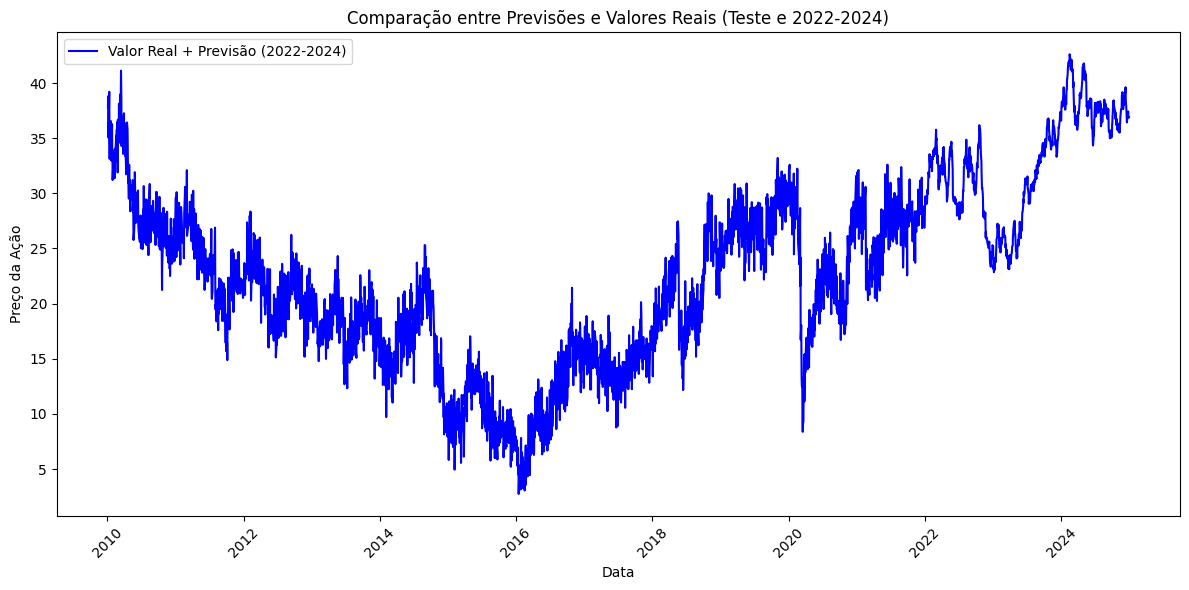

In [405]:
import matplotlib.pyplot as plt

# Garantir que o DataFrame com previsões e dados reais esteja disponível
df_model_with_preds['Date'] = pd.to_datetime(df_model_with_preds['Date'])

# Plotando as previsões vs reais para os dados de teste e as previsões para 2022-2024
plt.figure(figsize=(12, 6))

# Plotando os valores reais até 2021 e as previsões para 2022-2024
plt.plot(df_model_with_preds['Date'], df_model_with_preds['target'], label='Valor Real + Previsão (2022-2024)', color='blue')

# Plotando as previsões feitas pelo modelo para o teste (Ridge Regression ou outro)
# As previsões feitas pelo modelo para o treino devem estar disponíveis em y_pred_ridge (o código original usaria isso).
# plt.plot(train['Date'], y_pred_ridge, label='Previsto (Ridge Regression)', linestyle='--', color='red')

# Adicionando título e rótulos
plt.legend()
plt.title('Comparação entre Previsões e Valores Reais (Teste e 2022-2024)')
plt.xlabel('Data')
plt.ylabel('Preço da Ação')

# Ajustando a exibição das datas
plt.xticks(rotation=45)

# Ajuste para que os elementos não se sobreponham
plt.tight_layout()

# Mostrar o gráfico
plt.show()


### Ridge Model

Previsão usando o modelo Ridge Regression (melhor performou no MAE, RMSE e R²)

### Dataframe da previsão

### Visualização da Previsão